In [155]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [156]:
data = pd.read_csv('.\data1mins.csv')

In [157]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [158]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [159]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [160]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2069, 5, 16),
 datetime.date(2087, 6, 19),
 datetime.date(2218, 4, 16),
 datetime.date(2254, 9, 21),
 datetime.date(2251, 2, 20),
 datetime.date(2228, 2, 21),
 datetime.date(2131, 6, 21),
 datetime.date(2233, 11, 21),
 datetime.date(2131, 10, 18),
 datetime.date(2032, 8, 19),
 datetime.date(2114, 6, 21),
 datetime.date(2151, 1, 21),
 datetime.date(2066, 9, 16),
 datetime.date(2081, 1, 16),
 datetime.date(2165, 8, 15),
 datetime.date(2063, 12, 20),
 datetime.date(2056, 6, 15),
 datetime.date(2170, 12, 20),
 datetime.date(2118, 2, 17),
 datetime.date(2161, 12, 17),
 datetime.date(2048, 11, 19),
 datetime.date(2048, 10, 15),
 datetime.date(2215, 8, 17),
 datetime.date(2017, 9, 21),
 datetime.date(2021, 4, 15),
 datetime.date(2153, 2, 15),
 datetime.date(2205, 4, 18),
 datetime.date(2215, 3, 16),
 datetime.date(2155, 6, 19),
 datetime.date(2064, 5, 15),
 datetime.date(2247, 10, 21),
 datetime.date(2161, 1, 15),
 datetime.date(2097, 5, 16),
 datetime.date(2251, 7, 17),
 datet

In [161]:
import numpy as np
import pandas as pd
import datetime
from ta.volume import MFIIndicator, OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator

In [162]:

def alpha(
    data: pd.DataFrame,
    params: dict,
    expiration_dates=None,   # iterable[date] hoặc None
):
    """
    Cột bắt buộc: ['Date','Open','High','Low','Close','Volume']
    params:
      - t1: (nếu bạn dùng lowpass_filter cho Close_filtered)
      - w1: cửa sổ chỉ báo (MFI/ATR)
      - t2, t3: ngưỡng MFI vào lệnh (giữ nguyên logic của bạn)
      - t4, t5: ngưỡng MFI thoát lệnh (giữ nguyên logic của bạn)

      -- ATR-based risk params --
      - atr_sl: hệ số SL theo ATR (vd 0.8)
      - atr_tp: hệ số TP theo ATR (vd 1.2)
      - use_trailing: True/False (trailing SL mỗi bar)
      - trailing_threshold: hệ số ATR để bắt đầu trailing (vd 0.5 = chỉ trailing khi profit > 0.5*ATR)
      - exec_on_close: True/False (True = ra/vào tính tại close của bar hiện tại;
                                   False = tín hiệu tại bar t, thực thi bar t+1 để tránh lookahead)
      
      -- Volatility-adjusted params --
      - atr_lookback: lookback window cho average ATR (vd 50)
      - volatility_threshold: multiplier để xác định high volatility (vd 2.0 = ATR > 2x average)
      - high_vol_atr_sl: SL multiplier khi high volatility (vd 0.5 = tighter SL)
      - high_vol_atr_tp: TP multiplier khi high volatility (vd 0.8 = closer TP)
      
      -- Volume filter params --
      - use_volume_filter: True/False để bật/tắt volume filter
      - volume_window: window cho SMA của volume (vd 20)
      - volume_multiplier: entry chỉ khi Volume > multiplier * Volume_SMA (vd 1.0)
    """
    df = data.copy()

    # Ép kiểu datetime
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])

    # (Tuỳ bạn có dùng lọc hay không; bên dưới dùng Close thô cho chỉ báo)
    # Nếu muốn dùng lọc: hãy thay close_src = df['Close_filtered']

    close_src = df['Close']

    # Tính chỉ báo
    w1 = params['w1']
    df['MFI'] = MFIIndicator(high=df['High'], low=df['Low'], close=close_src,
                             volume=df['Volume'], window=w1).money_flow_index()
    
    df['ATR'] = AverageTrueRange(high=df['High'], low=df['Low'], close=close_src,
                                 window=w1).average_true_range()
    
    df['EMA_short'] = df['Close'].ewm(span=params['ema_short'], adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=params['ema_long'], adjust=False).mean()

    df['ADX'] = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], 
                             window=params['adx_win']).adx()

    # Ngưỡng logic MFI gốc của bạn
    t2 = params['t2']  # vào short khi MFI < t2
    t3 = params['t3']  # vào long  khi MFI > t3
    t4 = params['t4']  # thoát short khi MFI > t4
    t5 = params['t5']  # thoát long  khi MFI < t5

    # Tham số ATR quản trị rủi ro
    atr_sl = params.get('atr_sl', 0.8)       # SL = ATR * atr_sl
    atr_tp = params.get('atr_tp', 1.2)       # TP = ATR * atr_tp
    use_trailing = params.get('use_trailing', True)
    trailing_threshold = params.get('trailing_threshold', 0.5)  # Threshold để bắt đầu trailing
    exec_on_close = params.get('exec_on_close', True)

    expiration_set = set(expiration_dates) if expiration_dates is not None else set()
    warmup = w1  # chờ đủ ATR/MFI

    # Trạng thái
    pos = 0                 # -1 / 0 / +1
    position = []
    entry_price = np.nan
    sl = np.nan
    tp = np.nan
    trailing_active = False  # Flag để tracking trạng thái trailing

    # Để thực thi "tín hiệu t → khớp lệnh ở t+1" (tránh lookahead)
    desired_next = None   # vị thế mong muốn (áp dụng cho bar kế tiếp)
    prev_desired = 0
    multiplier = params['mult']

    for i in range(len(df)):
        ts   = df['Date'].iat[i]
        price= df['Close'].iat[i]
        MFI  = df['MFI'].iat[i]
        ATR  = df['ATR'].iat[i]
    
        is_uptrend = df['EMA_short'].iat[i] >= df['EMA_long'].iat[i]
        is_downtrend = df['EMA_short'].iat[i] <= df['EMA_long'].iat[i]
        volume = df['Volume'].iat[i]
        
       
        ADX_val = df['ADX'].iat[i]
        
        strong_trend = ADX_val > params['adx']  # ADX condition for strong trend

        # --- Thực thi lệnh từ bar trước (nếu chọn exec ở t+1) ---
        if not exec_on_close:
            # Ở bar i, thực thi quyết định của bar i-1
            if i == 0:
                pos = 0
            else:
                pos = prev_desired

        # Trong giai đoạn warmup hoặc NaN -> phẳng và reset risk state
        if (i < warmup) or np.isnan(MFI) or np.isnan(ATR) or np.isnan(ADX_val):
            pos = 0
            entry_price = np.nan; sl = np.nan; tp = np.nan
            trailing_active = False
            position.append(pos)
            prev_desired = pos if not exec_on_close else pos  # giữ đồng bộ
            continue

        # --- Kiểm tra điều kiện kích hoạt trailing ---
        if pos != 0 and use_trailing and not trailing_active:
            if pos == 1:  # Long position
                # Kích hoạt trailing khi profit > trailing_threshold * ATR
                if price > entry_price + trailing_threshold * ATR:
                    trailing_active = True
            elif pos == -1:  # Short position
                # Kích hoạt trailing khi profit > trailing_threshold * ATR
                if price < entry_price - trailing_threshold * ATR:
                    trailing_active = True

        # --- Cập nhật trailing SL nếu đang có vị thế và trailing đã kích hoạt ---
        if pos != 0 and use_trailing and trailing_active:
            if pos == 1:
                # Long: kéo SL lên theo Close - k*ATR
                new_sl = price - atr_sl * ATR
                sl = max(sl, new_sl) if not np.isnan(sl) else new_sl
            else:
                # Short: kéo SL xuống theo Close + k*ATR
                new_sl = price + atr_sl * ATR
                sl = min(sl, new_sl) if not np.isnan(sl) else new_sl

        # --- Kiểm tra chạm SL/TP (đóng lệnh) ---
        # Lưu ý: nếu bạn dùng dữ liệu OHLC intrabar, có thể kiểm tra theo High/Low thay vì Close
        if pos == 1:
            # Long: TP khi giá >= tp, SL khi giá <= sl
            if not np.isnan(tp) and price >= tp:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False
            elif not np.isnan(sl) and price <= sl:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False

        elif pos == -1:
            # Short: TP khi giá <= tp, SL khi giá >= sl
            if not np.isnan(tp) and price <= tp:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False
            elif not np.isnan(sl) and price >= sl:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False

        # --- Thoát theo MFI gốc của bạn (ưu tiên sau SL/TP) ---
        if pos == -1 and (MFI > t4):
            pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False
        elif pos == 1 and (MFI < t5):
            pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False

        # --- Entry theo MFI gốc của bạn (chỉ khi đang phẳng) ---
        if pos == 0:
            # vào short khi MFI < t2  (theo code gốc của bạn)
            if MFI < t2 and is_downtrend and strong_trend:
                pos = -1
                entry_price = price
                sl = entry_price + atr_sl * ATR
                tp = entry_price - atr_tp * ATR
                trailing_active = False  # Reset trailing state
            # vào long khi MFI > t3
            elif MFI > t3 and is_uptrend and strong_trend:
                pos = 1
                entry_price = price
                sl = entry_price - atr_sl * ATR
                tp = entry_price + atr_tp * ATR
                trailing_active = False  # Reset trailing state

        # --- EOD rules (giữ đúng tinh thần c   ode gốc: chỉ đóng short lúc 14:25) ---
        if ts.hour == 14 and ts.minute == 25:
            if pos == -1:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False

        if ts.hour == 14 and ts.minute == 45:
            if len(position) > 0:
                if ts.date() in expiration_set:
                    pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan; trailing_active = False

        # --- Ghi position ---
        if exec_on_close:
            # quyết định đã áp dụng ngay ở bar này
            position.append(pos)
            prev_desired = pos
        else:
            # lưu desired để thực thi bar sau
            desired_next = pos
            # pos thực thi hiện tại là quyết định của bar trước (đã set ở đầu vòng)
            position.append(pos)
            prev_desired = desired_next

    df['pos'] = position
    return df

In [163]:
params = {'t1': 0.75, 't2': 15, 't3': 66, 't4': 55, 't5': 53, 'w1': 21, 'atr_sl': 0.325, 'atr_tp': 2.5, 'use_trailing': True, 'exec_on_close': True, 'ema_short': 20, 'ema_long': 100, 'trailing_threshold': 0.75, 'volume_window':20, 'min_win':10, 'mult': 0.5, 'adx_win': 14, 'adx':14}

In [164]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 10.5
MDD: 51.3 (3.28%)

   Total trading quantity: 844
         Profit per trade: 1.87
             Total Profit: 1943.9
         Profit after fee: 1578.0
 Trading quantity per day: 0.44
 Profit per day after fee: 0.83
                   Return: 0.13
          Profit per year: 207.11
                  HitRate: 0.47
          HitRate per day: 0.25


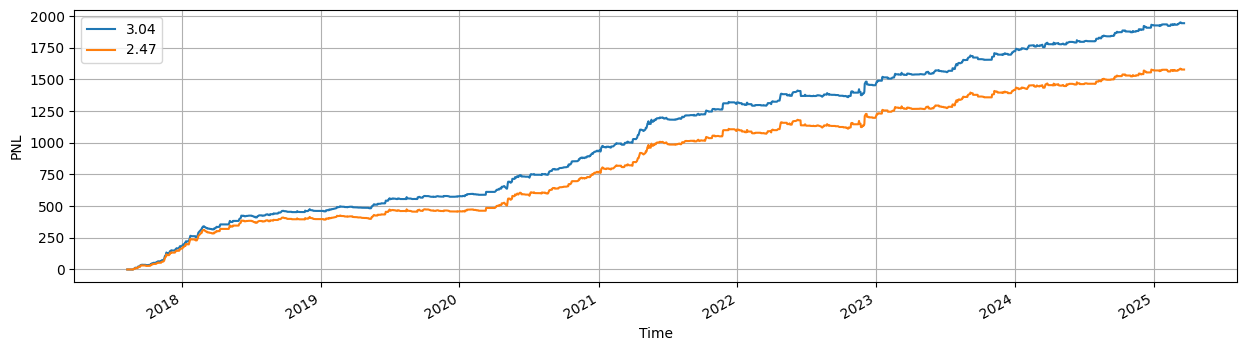

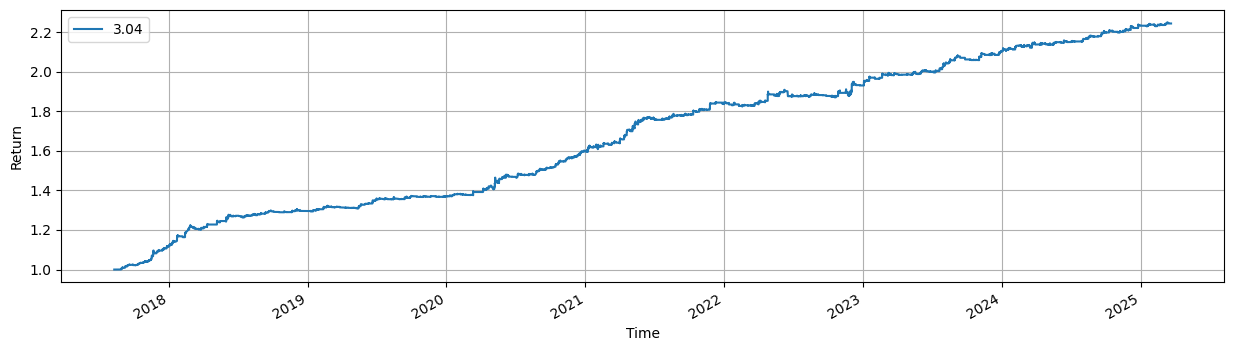

In [165]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [166]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [167]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [168]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date","Close", "pos"]]
df_result

Loading ITables v2.5.2 from the internet... (need help?)


In [169]:
df_result.to_csv("alpha1_pos.csv", index=False)